# GridSearch



GridSearchCV – это инструмент для автоматического подбора параметров моделей машинного обучения. GridSearchCV находит наилучшие параметры путем обычного перебора: он создает модель для каждой возможной комбинации параметров из заданной сетки.

Cоздадим свой датасет для демоснтрации:

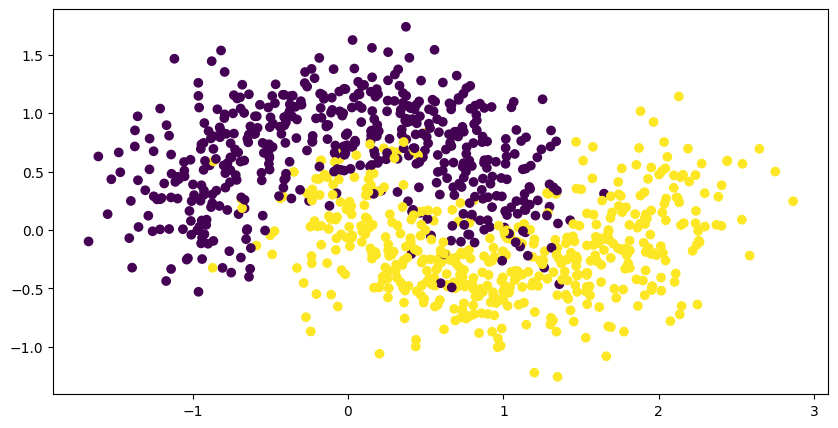

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

x, y = make_moons(n_samples=1000, noise=0.3, random_state=42)

plt.figure(figsize=(10, 5))
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

Отложим test:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, stratify=y, random_state=42
)

Попробуем подобрать параметры модели:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import KFold

"""
Parameters for GridSearchCV:
estimator — model
cv — num of fold to cross-validation splitting
param_grid — parameters names
scoring — metrics
n_jobs — number of jobs to run in parallel, -1 means using all processors.
"""

model = GridSearchCV(
    estimator=KNeighborsClassifier(),
    cv=KFold(5, shuffle=True, random_state=42),
    param_grid={
        "n_neighbors": np.arange(1, 31),
        "metric": ["euclidean", "manhattan"],
        "weights": ["uniform", "distance"],
    },
    scoring="accuracy",
    n_jobs=-1,
)
model.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Выведем лучшие гиперпараметры для модели, которые подобрали:

In [ ]:
print("Metric:", model.best_params_["metric"])
print("Num neighbors:", model.best_params_["n_neighbors"])
print("Weigths:", model.best_params_["weights"])

Metric: euclidean
Num neighbors: 30
Weigths: distance


Объект `GridSearchCV` можно использовать как обычную модель.

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_test)
print(
    f"Percent correct predictions {np.round(accuracy_score(y_pred=y_pred, y_true=y_test)*100,2)} %"
)

Percent correct predictions 95.5 %


Мы можем извлечь дополнительные данные о кросс-валидации и по ключу обратиться к результатам всех моделей:

In [ ]:
list(model.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_metric',
 'param_n_neighbors',
 'param_weights',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

Выведем для примера `mean_test_score`:

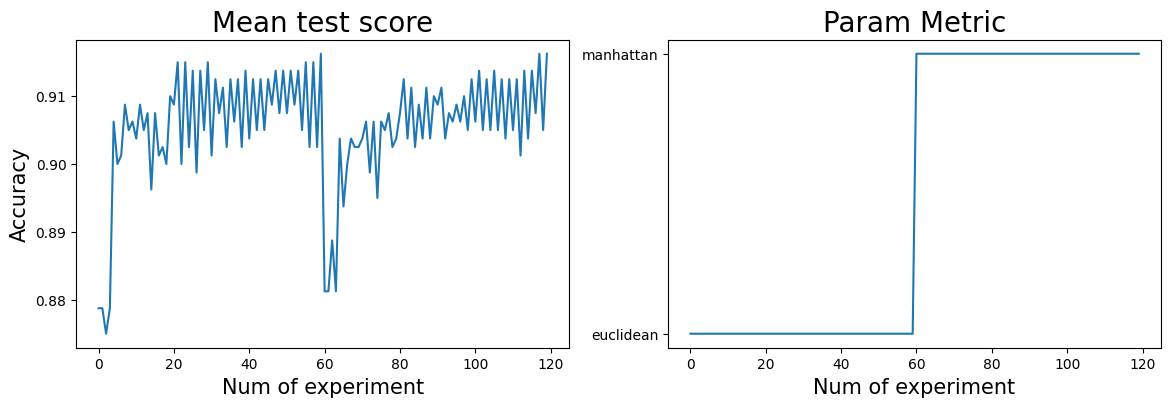

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(model.cv_results_["mean_test_score"])
plt.title("Mean test score", size=20)
plt.xlabel("Num of experiment", size=15)
plt.ylabel("Accuracy", size=15)

plt.subplot(122)
plt.plot(model.cv_results_["param_metric"])
plt.title("Param Metric", size=20)
plt.xlabel("Num of experiment", size=15)

plt.show()

Построим, например, при фиксированных остальных параметрах (равных лучшим параметрам), качество модели на валидации в зависимости от числа соседей:

In [ ]:
selected_means = []
selected_std = []
num_neighbors = []
for ind, params in enumerate(model.cv_results_["params"]):
    if (
        params["metric"] == model.best_params_["metric"]
        and params["weights"] == model.best_params_["weights"]
    ):
        num_neighbors.append(params["n_neighbors"])
        selected_means.append(model.cv_results_["mean_test_score"][ind])
        selected_std.append(model.cv_results_["std_test_score"][ind])

Построим error bar для сравнения разброса ошибки при разном количестве соседей Neighbors.

Видим, что на самом деле большой разницы в числе соседей, начиная с 11, и нет.

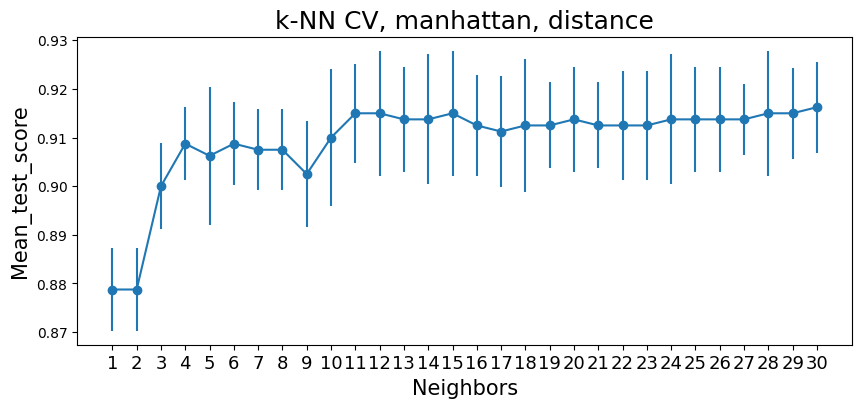

In [ ]:
plt.figure(figsize=(10, 4))
plt.title(f"k-NN CV, {params['metric']}, {params['weights']}", size=18)
plt.errorbar(num_neighbors, selected_means, yerr=selected_std, fmt="-o")
plt.xticks(num_neighbors, size=13)
plt.ylabel("Mean_test_score", size=15)
plt.xlabel("Neighbors", size=15)

plt.show()

# RandomizedSearch

Альтернативой GridSearch является [RandomizedSearch 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Если в GridSearch поиск параметров происходит по фиксированному списку значений, то RandomizedSearch умеет работать с непрерывными значениями, случайно выбирая тестируемые значения, что может привести к более точной настройке гиперпараметров.

Вы в явном виде указываете, сколько точек вы будете семплировать.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

"""
Parameters for RandomizedSearchCV:
estimator — model
cv — num of fold to cross-validation splitting
param_distributions — parameters names
n_iter — number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
scoring — metrics
n_jobs — number of jobs to run in parallel, -1 means using all processors.
"""

model = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    n_iter=100,
    cv=KFold(5, shuffle=True, random_state=42),
    param_distributions={
        "n_neighbors": np.arange(1, 31),
        "metric": ["euclidean", "manhattan"],
        "weights": ["uniform", "distance"],
    },
    scoring="accuracy",
    n_jobs=-1,
)
model.fit(x_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

Выведем лучшие гиперпараметры для модели, которые подобрали:

In [ ]:
print("Metric:", model.best_params_["metric"])
print("Num neighbors:", model.best_params_["n_neighbors"])
print("Weigths:", model.best_params_["weights"])

Metric: manhattan
Num neighbors: 30
Weigths: distance


Как видим, параметры близки к выбранным полным перебором.

Объект `RandomizedSearchCV` также можно использовать как обычную модель.

In [ ]:
y_pred = model.predict(x_test)
print(
    f"Percent correct predictions {np.round(accuracy_score(y_pred=y_pred, y_true=y_test)*100,2)} %"
)

Percent correct predictions 94.5 %


Точность уменьшилась на 0.5%, но поиск параметров был быстрее.

# Optuna

В практических задачах, чаще всего вы будете использовать этот фреймворк для подбора гиперпараметров алгоритма — [**Optuna** 🛠️[doc]](https://optuna.org/).


In [ ]:
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


В Optuna выделяются две основные сущности:

1. **`Study`** – процесс оптимизации, основанный на целевой функции **`Objective`**.
2. **`Trial`** – одно конкретное выполнение целевой функции **`Objective`** с набором гиперпараметров.



В функции **`Objective`** реализуется основной код, который отвечает за обучение модели и расчет метрики. Optuna многократно вызывает **`Objective`**, подбирая лучшие гиперпараметры.

Пример структуры функции **`Objective`**:
```python
def objective(trial, ...):
    # fit model
    # calculate score
    return score
```


**`Trial`** объект используется для задания гиперпараметров, которые будут перебираться во время оптимизации. Для каждого типа параметров есть свои методы. Например:

- **Целочисленные параметры**:
```python
neighbors = trial.suggest_int('neighbors', 5, 8)
```

- **Категориальные параметры**:
```python
metric = trial.suggest_categorical('metric', ["euclidean", "manhattan", "chebyshev"])
```

- **Непрерывные значения (float)**:
```python
float_value = trial.suggest_float('float_value', 0, 1.5)  
```

- **Равномерное распределение**:
```python
uniform_value = trial.suggest_uniform('uniform_value', 0.0, 1.0)
```





Инициализируем объект **`study`**, который выполняет процесс оптимизации и сохраняет историю результатов. В зависимости от цели (максимизация метрики или минимизация ошибки) можно задать направление оптимизации:

- Для максимизации метрики:
```python
study = optuna.create_study(direction='maximize')
```

- Для минимизации метрики:
```python
study = optuna.create_study(direction='minimize')
```



Рассмотрим на примере оптимизации прааметров для k-NN:

In [ ]:
import optuna
from optuna.samplers import TPESampler, RandomSampler
from sklearn.model_selection import cross_val_score, KFold

# Define function which will optimized

def objective(trial):
    # boundaries for the optimizer's
    n_neighbors = trial.suggest_int("n_neighbors", 1, 31, step=1)
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan"])
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])

    # create new model(and all parameters) every iteration
    model = KNeighborsClassifier(
        n_neighbors = n_neighbors,
        metric = metric,
        weights = weights,
    )
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    accuracy = cross_val_score(
        model, x_train, y_train, cv=kf, scoring="accuracy"
    ).mean()

    return accuracy


# Create "exploration"
study = optuna.create_study(
    direction="maximize", study_name="Optimizer", sampler=RandomSampler(42)
)

study.optimize(
    objective, n_trials=50
)  # The more iterations, the higher the chances of catching the most optimal hyperparameters

[I 2024-10-11 15:35:34,844] A new study created in memory with name: Optimizer
[I 2024-10-11 15:35:34,913] Trial 0 finished with value: 0.9099903316343293 and parameters: {'n_neighbors': 12, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.9099903316343293.
[I 2024-10-11 15:35:34,931] Trial 1 finished with value: 0.8999840425032618 and parameters: {'n_neighbors': 5, 'metric': 'manhattan', 'weights': 'distance'}. Best is trial 0 with value: 0.9099903316343293.
[I 2024-10-11 15:35:34,981] Trial 2 finished with value: 0.8800090112922757 and parameters: {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.9099903316343293.
[I 2024-10-11 15:35:35,039] Trial 3 finished with value: 0.9012277885725549 and parameters: {'n_neighbors': 6, 'metric': 'manhattan', 'weights': 'uniform'}. Best is trial 0 with value: 0.9099903316343293.
[I 2024-10-11 15:35:35,058] Trial 4 finished with value: 0.9137356499863891 and parameters: {'n_nei

Давайте посмотрим на историю оптимизации нашей метрики:

In [ ]:
optuna.visualization.plot_optimization_history(study)

Можем посмотреть, с какими параметрами какие результаты получились, и сделать выводы, в каких диапазонах лучше подбирать параметры:

In [ ]:
params = ["n_neighbors", "metric", "weights"]
optuna.visualization.plot_slice(study, params=params, target_name="accuracy")

Выведем лучшие параметры:

In [ ]:
# show best params
study.best_params

{'n_neighbors': 29, 'metric': 'manhattan', 'weights': 'distance'}

Optuna оценивает важность параметров для лучшего результата:

In [ ]:
optuna.visualization.plot_param_importances(study)

Обучим алгоритм на лучших параметрах:

In [ ]:
model = KNeighborsClassifier(
    n_neighbors = study.best_params["n_neighbors"],
    metric = study.best_params["metric"],
    weights = study.best_params["weights"],

)

model.fit(x_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=29, weights='distance')

Оценим качество:

In [ ]:
y_pred = model.predict(x_test)
print(
    f"Percent correct predictions {np.round(accuracy_score(y_pred=y_pred, y_true=y_test)*100,2)} %"
)

Percent correct predictions 95.0 %


Удалось подобрать параметры значительно быстрее